#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Для этого необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Описание данных:

Данные находятся в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Для выполнения поставленной задачи нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.




## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df = df.resample('1H').sum()

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные загружены. Выполнено ресемплирование по одному часу.

## Анализ

In [ ]:
df.index.is_monotonic

True

Даты и время расположены в хронологическом порядке.

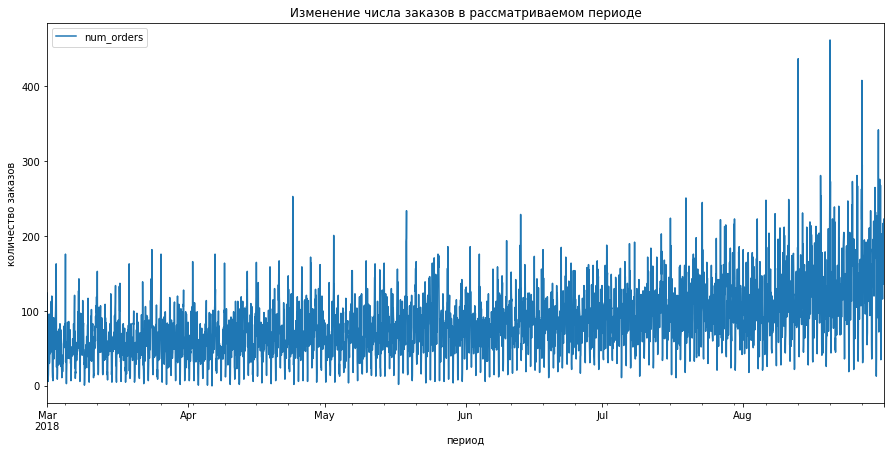

In [ ]:
plt.figure(figsize=(15, 7))
df.plot(ax=plt.gca(), xlabel='период', ylabel='количество заказов')
plt.title('Изменение числа заказов в рассматриваемом периоде');

В рассматрмваемом периоде наблюдается тенденция к увеличению числа заказов

In [ ]:
decomposed = seasonal_decompose(df)

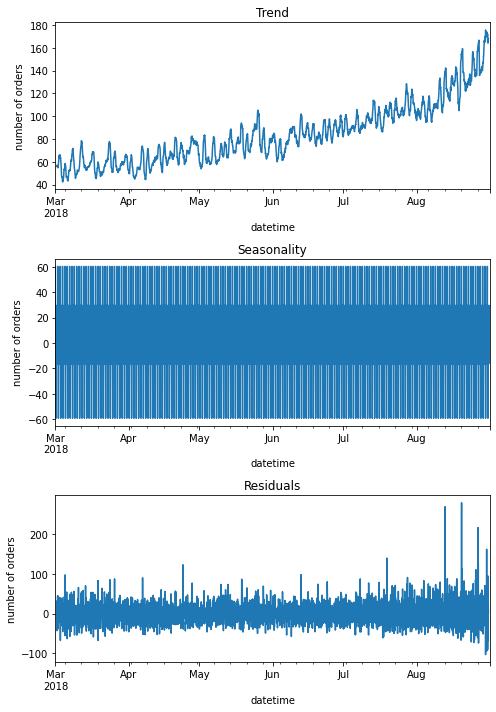

In [ ]:
plt.figure(figsize=(7, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), ylabel='number of orders')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), ylabel='number of orders')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), ylabel='number of orders')
plt.title('Residuals')
plt.tight_layout()

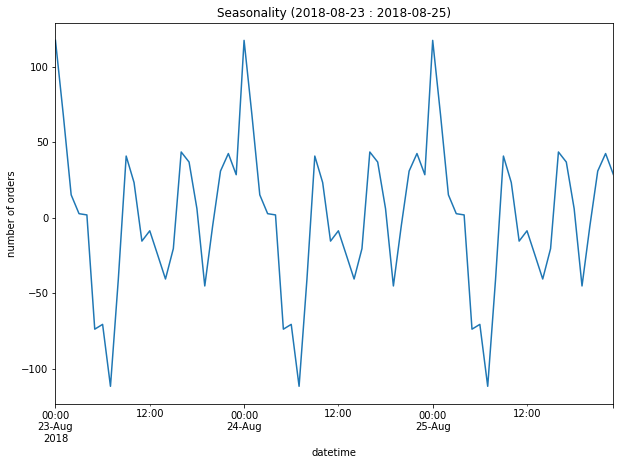

In [ ]:
decomposed_s = seasonal_decompose(df['2018-08-23':'2018-08-25'])
plt.figure(figsize=(10, 7))
decomposed_s.seasonal.plot(ax=plt.gca(), ylabel='number of orders')
plt.title('Seasonality (2018-08-23 : 2018-08-25)');

Наблюдается тренд на повышение количества заказов

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    return data

Создана функция для добавления новых признаков - календарных(месяц, день, день недели), отстающих, признака скользящего среднего и стандартного отклонения.

In [ ]:
make_features(df, 24, 24)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000,65.948143
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667,63.268908
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667,63.105487


In [ ]:
def grafic(index, xlabel, title):
    (df.pivot_table(index=index, values='num_orders', aggfunc='mean')
       .plot.bar(xlabel=xlabel, ylabel='число заказов',legend=None, figsize=(7,5), title=title)
    );

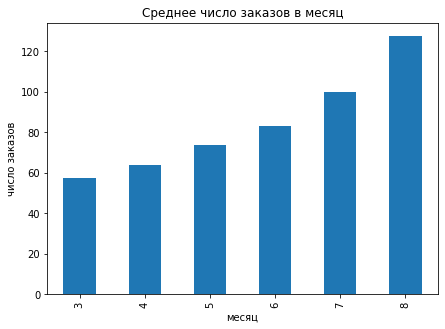

In [ ]:
grafic('month', 'месяц', 'Среднее число заказов в месяц')

среднее число заказов от месяца к месяцу увеличивалось и в августе достигло своего максимума

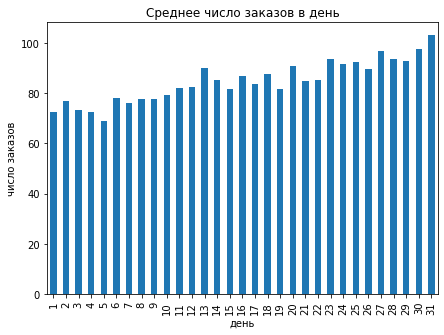

In [ ]:
grafic('day', 'день', 'Среднее число заказов в день')

среднее число заказов имеет тенденцию к увеличению к концу месяца, самое маленькое в первый день месяца , самое большое в последние дни.

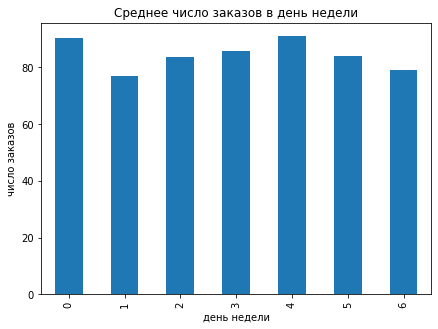

In [ ]:
grafic('dayofweek', 'день недели', 'Среднее число заказов в день недели')

среднее число заказов больше в понедельник и пятницу

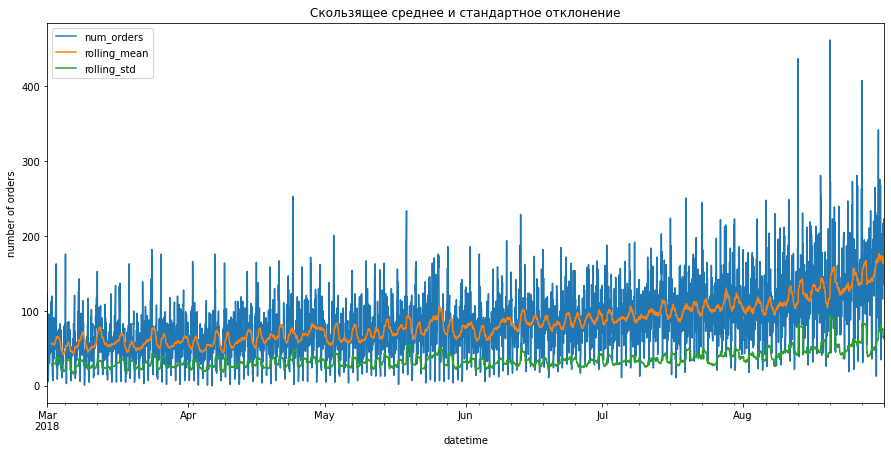

In [ ]:
plt.figure(figsize=(15, 7))
df['num_orders'].plot(ax=plt.gca(), label='num_orders', ylabel='number of orders')
df['rolling_mean'].plot(ax=plt.gca(), label='rolling_mean')
df['rolling_std'].plot(ax=plt.gca(), label='rolling_std')
plt.legend()
plt.title('Скользящее среднее и стандартное отклонение');

In [ ]:
df = df.dropna()

In [ ]:
df

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333,29.409650
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667,26.730404
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000,29.250511
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667,29.345734
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333,29.322019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000,65.948143
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667,63.268908
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667,63.105487


В рассматриваемом периоде наблюдается тренд на повышение количества заказов. В данные были добавлены новые признаки - месяц, день, день недели, скользящее среднее и стандартное отклонение с окном размером 24, также сформированы отстающие признаки. Строки с пропусками были удалены.

## Обучение

**Разбивка на обучающую, валидационную и тестовую выборки**

In [ ]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                             shuffle=False,
                                                                             test_size=0.1,
                                                                             random_state=42)

In [ ]:
features_train

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333,29.409650
2018-03-02 01:00:00,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667,26.730404
2018-03-02 02:00:00,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000,29.250511
2018-03-02 03:00:00,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667,29.345734
2018-03-02 04:00:00,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333,29.322019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 11:00:00,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,137.250000,79.768279
2018-08-13 12:00:00,8,13,0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,139.875000,78.868251
2018-08-13 13:00:00,8,13,0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,138.583333,79.408639


In [ ]:
features_test

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 16:00:00,8,13,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,139.541667,79.784481
2018-08-13 17:00:00,8,13,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,139.166667,79.739612
2018-08-13 18:00:00,8,13,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,140.708333,79.609634
2018-08-13 19:00:00,8,13,0,104.0,152.0,144.0,175.0,102.0,119.0,92.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,141.791667,78.892871
2018-08-13 20:00:00,8,13,0,91.0,104.0,152.0,144.0,175.0,102.0,119.0,...,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,142.166667,78.617216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000,65.948143
2018-08-31 20:00:00,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667,63.268908
2018-08-31 21:00:00,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667,63.105487


In [ ]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((3952, 29), (3952,), (440, 29), (440,))

**LinearRegression**

In [ ]:
cv = TimeSeriesSplit(n_splits=3)

In [ ]:
def func_rmse(target, predict):
    rmse = mean_squared_error(target, predict)**0.5
    return rmse

In [ ]:
rmse = make_scorer(func_rmse)

In [ ]:
model_lr = LinearRegression().fit(features_train, target_train)
scores = cross_val_score(model_lr, features_train, target_train, scoring=rmse, cv=cv).mean()
print('RMSE:', scores)

RMSE: 27.530320428282597


**RandomForestRegressor**

In [ ]:
best_model_rf = None
best_result_rf = 48
n_estimators = 0
max_depth = 0
for est in range(30, 51, 10):
    for depth in range(14, 17):
        model_rf = RandomForestRegressor(random_state=42, n_estimators=est,
                                        max_depth=depth)
        model_rf.fit(features_train, target_train)
        result = cross_val_score(model_rf, features_train, target_train, scoring=rmse, cv=cv).mean()
        if result < best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result
            n_estimators = est
            max_depth = depth
print("RMSE", best_result_rf, ', n_estimators =', n_estimators, ', max_depth', max_depth)

RMSE 27.60108853435108 , n_estimators = 50 , max_depth 16


**CatBoostRegressor**

In [ ]:
best_model_cb = None
best_result_cb = 48
iterations = 0
depth = 0
for iteration in range(100, 151, 50):
    for depth in range(10, 15):
        model_cb = CatBoostRegressor(depth=depth, iterations=iteration, random_state=42)
        model_cb.fit(features_train, target_train, verbose=100)
        result_cb = cross_val_score(model_cb, features_train, target_train, scoring=rmse, cv=cv).mean()
        if result_cb < best_result_cb:
            best_model_cb = model_cb
            best_result_cb = result_cb
            iterations = iteration
            depth = depth
print("RMSE", best_result_cb, ', iterations =', iterations, ', depth', depth)

Learning rate set to 0.330732
0:	learn: 33.1662343	total: 108ms	remaining: 10.7s
99:	learn: 5.6582380	total: 5.43s	remaining: 0us
Learning rate set to 0.265675
0:	learn: 26.6256861	total: 35.8ms	remaining: 3.54s
1:	learn: 24.0270881	total: 74.2ms	remaining: 3.63s
2:	learn: 21.9761424	total: 107ms	remaining: 3.45s
3:	learn: 20.3208919	total: 139ms	remaining: 3.33s
4:	learn: 19.0494516	total: 178ms	remaining: 3.38s
5:	learn: 17.8803731	total: 211ms	remaining: 3.3s
6:	learn: 16.9751193	total: 249ms	remaining: 3.31s
7:	learn: 15.9610771	total: 283ms	remaining: 3.26s
8:	learn: 15.0841646	total: 316ms	remaining: 3.19s
9:	learn: 14.4131938	total: 355ms	remaining: 3.19s
10:	learn: 14.0130491	total: 387ms	remaining: 3.13s
11:	learn: 13.3950849	total: 419ms	remaining: 3.08s
12:	learn: 12.9036519	total: 465ms	remaining: 3.11s
13:	learn: 12.4357256	total: 507ms	remaining: 3.11s
14:	learn: 11.8061679	total: 547ms	remaining: 3.1s
15:	learn: 11.4716156	total: 587ms	remaining: 3.08s
16:	learn: 10.9623

Было обучено три модели - LinearRegression, RandomForestRegressor, CatBoostRegressor. Лучшее качество у модели LinearRegression . Данную модель будем проверять на тестовой выборке.

## Тестирование

In [ ]:
predict = model_lr.predict(features_test)
print('RMSE:', mean_squared_error(target_test, predict)**0.5)

RMSE: 45.562756217056766


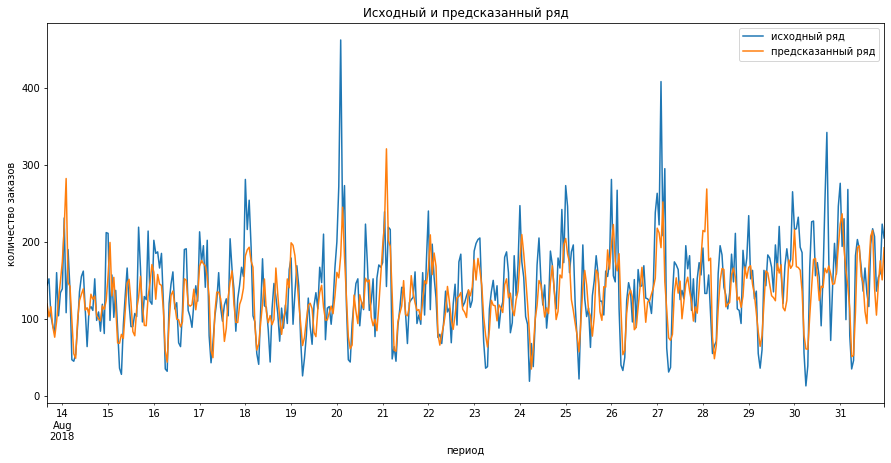

In [ ]:
plt.figure(figsize=(15, 7))
target_test.plot(ax=plt.gca(), label='исходный ряд', ylabel='количество заказов')
pd.Series(predict, index=target_test.index).plot(ax=plt.gca(), label='предсказанный ряд', xlabel='период')
plt.legend()
plt.title('Исходный и предсказанный ряд');

Для проекта были использованы исторические данные о заказах такси в аэропортах (период март-август 2018). В данном периоде наблюдается тренд на повышение количества заказов. Было выполнено ресемплирование по одному часу. В данные были добавлены новые признаки - месяц, день, день недели, скользящее среднее и стандартное отклонение с окном размером 24, также сформированы отстающие признаки (24 шага). Строки с пропусками были удалены. Данные были разбиты на обучающую, валидационную и тестовую выборки. Было обучено три модели - LinearRegression, RandomForestRegressor, CatBoostRegressor. Лучшее качество у модели LinearRegression. Данная модель была проверена на тестовой выборке и показала также хорошее качество 45.562756217056766. Т.о. модель LinearRegression подходит  для предсказания количества заказов такси на следующий час.